In [2]:
import string
import pandas as pd
from datetime import datetime
from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
import matplotlib.pyplot as plt
import tensorflow as tf
from nltk import FreqDist
from nltk import word_tokenize
from keras.models import Model
from wordcloud import WordCloud
from nltk.corpus import stopwords
#from trustpilot import get_data
from nltk.stem import PorterStemmer
from keras.utils import to_categorical
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Input, Dense, Dropout, Activation, Embedding

Using TensorFlow backend.


In [3]:
def clean_str(s):
    s.replace('  ', '').replace('\n', '')
    return s


def clean_date_time(found_time):
    found_time = found_time[19:38].replace('T', ' ')
    return datetime.strptime(found_time, '%Y-%m-%d %H:%M:%S')

In [4]:
def get_data(url, page):
    user_name = []
    review_count = []
    review_score = []
    time_of_review = []
    review_title = []
    review_str = []

    for p in range(page):

        url_changer = url + str(p + 1)
        data = urlopen(Request(url_changer))
        soup_data = BeautifulSoup(data, 'html.parser')

        user_name_finder = soup_data.find_all('div', class_='consumer-information__name')
        review_count_finder = soup_data.find_all('div', class_='consumer-information__review-count')
        review_score_finder = soup_data.find_all(name='script', attrs={'type':'application/json', 'data-initial-state':'review-info'})
        time_of_review_finder = soup_data.find_all('script', attrs={'type': 'application/json', 'data-initial-state': 'review-dates'})
        review_title_finder = soup_data.find_all('h2', class_='review-content__title')
        review_str_finder = soup_data.find_all('p', class_='review-content__text')

        for i in range(len(user_name_finder)):

            name = clean_str(user_name_finder[i].text)
            review = int(review_count_finder[i].span.text[:-7])
            score = int(review_score_finder[i].text[-3])
            tempdate = clean_date_time(time_of_review_finder[i].text)
            title = review_title_finder[i].a.text
            comment = clean_str(review_str_finder[i].text)

            user_name.append(name)
            review_count.append(review)
            review_score.append(score)
            time_of_review.append(tempdate)
            review_title.append(title)
            review_str.append(comment)

    hsbc_scrape = pd.DataFrame(data=[time_of_review, review_count, review_score, review_title, review_str],
                      columns=user_name)
    hsbc_scrape = hsbc_scrape.T
    hsbc_scrape.columns = ['time_of_review', 'review_count', 'review_score', 'review_title', 'reviews']

    return hsbc_scrape

In [5]:
def remove_stop_words(words):
    return [x for x in words if x not in stop_words]


def remove_punctuate(words):
    return [x for x in words if x not in punctuate]


def stem_words(words):
    return [stemmer.stem(x) for x in words]

In [6]:
stemmer = PorterStemmer()

punctuate = list(string.punctuation)
punctuate.append('...')
punctuate.append('’')
punctuate.append("''")
punctuate.append('``')

stop_words = stopwords.words('english')
stop_words.append('ca')
stop_words.append('n\'t')
stop_words.append('\'s')
stop_words.append('\'re')
stop_words.append('\'ve')
stop_words.append('\'m')
stop_words.append('\'d')
stop_words = set(stop_words)

In [7]:
#Read dataframe from trustpilot website
hsbc_data = get_data(url = 'https://www.trustpilot.com/review/www.hsbc.co.uk?page=', page = 80)

In [8]:
# creating target columns -> rating
hsbc_data['rating'] = hsbc_data['review_score'].map(lambda x: 0 if x < 3 else (1 if x == 3 else 2))
count_rating = hsbc_data['rating'].value_counts()
class_weight = {0: 1, 1: 50, 2: 14}

In [9]:
#Convert all reviews to lowercase
hsbc_data['reviews'] = hsbc_data['reviews'].map(lambda x: x if type(x) != str else x.lower())

#Convert reviews to stream of tokens
hsbc_data['reviews'] = hsbc_data['reviews'].apply(word_tokenize)

#Remove punctuation marks from the comments
hsbc_data['reviews'] = hsbc_data['reviews'].apply(remove_punctuate)

#Extract stop words from the comments
hsbc_data['reviews'] = hsbc_data['reviews'].apply(remove_stop_words)

In [10]:
all_tokens = []
for i in hsbc_data['reviews']:
    for x in i:
        all_tokens.append(x)

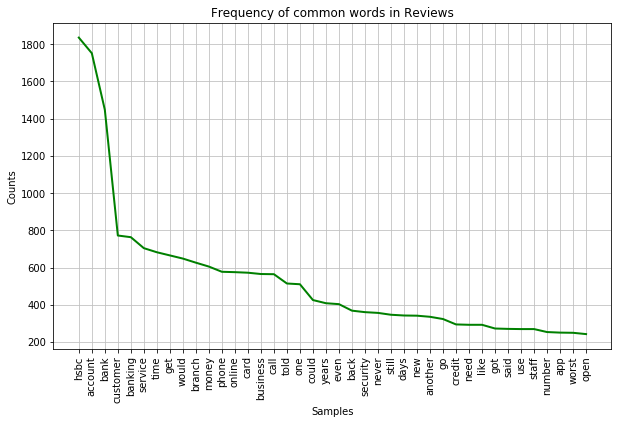

In [11]:
#Frequency of top 30 common words
freq_words = FreqDist(all_tokens)
plt.figure(figsize=(10,6))
plt.title('Frequency of common words in Reviews')
freq_words.plot(40, color='g')

In [12]:
#Stemming to normalise and couple sentences with same meaning
hsbc_data['reviews'] = hsbc_data['reviews'].apply(stem_words)

**LSTM Model**

In [13]:
X_independent = hsbc_data['reviews']
y_dependent = hsbc_data['rating']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_independent, y_dependent, test_size=0.2)

In [15]:
max_words = 1000
max_length = 300
token = Tokenizer(num_words = max_words)
token.fit_on_texts(X_train)
sequences = token.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_length)

In [16]:
def Recurrent_NN():
    inputs = Input(name='inputs', shape=[max_length])
    layer = Embedding(input_dim = max_words, output_dim = 50)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256)(layer)
    layer = Activation('relu')(layer)
    layer = Dense(1, name = 'out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs = inputs, outputs = layer)
    return model

In [17]:
data_model = Recurrent_NN()

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
data_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
data_model.fit(sequences_matrix, y_train, batch_size=128, epochs=10, validation_split=0.2,
          class_weight=class_weight)

Instructions for updating:
Use tf.cast instead.
Train on 1024 samples, validate on 256 samples
Epoch 1/10
1024/1024 [==============================] - 8s 8ms/step - loss: 2.0051 - accuracy: 0.0752 - val_loss: 1.8859 - val_accuracy: 0.0234
Epoch 2/10
1024/1024 [==============================] - 6s 5ms/step - loss: 0.9258 - accuracy: 0.0186 - val_loss: -2.0398 - val_accuracy: 0.0234
Epoch 3/10
1024/1024 [==============================] - 6s 6ms/step - loss: -2.1987 - accuracy: 0.0186 - val_loss: -5.3146 - val_accuracy: 0.0234
Epoch 4/10
1024/1024 [==============================] - 6s 6ms/step - loss: -4.4132 - accuracy: 0.0186 - val_loss: -8.6922 - val_accuracy: 0.0234
Epoch 5/10
1024/1024 [==============================] - 8s 8ms/step - loss: -5.8387 - accuracy: 0.0186 - val_loss: -8.7185 - val_accuracy: 0.0234
Epoch 6/10
1024/1024 [==============================] - 7s 6ms/step - loss: -5.8383 - accuracy: 0.0186 - val_loss: -8.7185 - val_accuracy: 0.0234
Epoch 7/10
1024/1024 [==========